<a href="https://colab.research.google.com/github/apriandito/nowcasting/blob/main/6_Monthly_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings("ignore")

import requests
import pandas as pd
import numpy as np
from sklearn.linear_model import ElasticNet, LinearRegression, Ridge, Lasso, BayesianRidge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import plotly.graph_objects as go
import shap
import matplotlib.pyplot as plt

Get API Key: http://alphavantage.co/

In [2]:
# Ambil data dari API
API_KEY = '8V7F020H9WXQRHLQ'
url = f"https://www.alphavantage.co/query?function=FX_DAILY&from_symbol=USD&to_symbol=IDR&apikey={API_KEY}&outputsize=full"
response = requests.get(url)
data = response.json()
timeseries = data.get("Time Series FX (Daily)", {})
timeseries

{'2025-05-01': {'1. open': '16674.00000',
  '2. high': '16674.00000',
  '3. low': '16594.00000',
  '4. close': '16597.00000'},
 '2025-04-30': {'1. open': '16782.00000',
  '2. high': '16782.00000',
  '3. low': '16589.00000',
  '4. close': '16594.00000'},
 '2025-04-29': {'1. open': '16857.00000',
  '2. high': '16857.00000',
  '3. low': '16753.00000',
  '4. close': '16754.00000'},
 '2025-04-28': {'1. open': '16824.00000',
  '2. high': '16863.00000',
  '3. low': '16819.00000',
  '4. close': '16849.00000'},
 '2025-04-25': {'1. open': '16799.00000',
  '2. high': '16879.00000',
  '3. low': '16799.00000',
  '4. close': '16824.00000'},
 '2025-04-24': {'1. open': '16875.00000',
  '2. high': '16884.00000',
  '3. low': '16849.00000',
  '4. close': '16864.00000'},
 '2025-04-23': {'1. open': '16857.00000',
  '2. high': '16884.00000',
  '3. low': '16844.00000',
  '4. close': '16859.00000'},
 '2025-04-22': {'1. open': '16803.00000',
  '2. high': '16864.00000',
  '3. low': '16799.00000',
  '4. close': 

In [3]:
df = pd.DataFrame.from_dict(timeseries, orient='index')
df.columns = ['Open', 'High', 'Low', 'Close']
df.index = pd.to_datetime(df.index)
df = df.sort_index()
df = df.astype(float)
df

,Open,High,Low,Close
2014-11-07,12120.0,12170.0,12115.0,12135.0
2014-11-10,12170.0,12170.0,12135.0,12150.0
2014-11-11,12200.0,12200.0,12200.0,12200.0
2014-11-12,12200.0,12218.0,12142.0,12197.0
2014-11-13,12197.0,12210.0,12142.0,12200.0
...,...,...,...,...
2025-04-25,16799.0,16879.0,16799.0,16824.0
2025-04-28,16824.0,16863.0,16819.0,16849.0
2025-04-29,16857.0,16857.0,16753.0,16754.0
2025-04-30,16782.0,16782.0,16589.0,16594.0


In [4]:
# Ubah data ke bulanan (ambil close terakhir tiap bulan)
df_monthly = df.resample('M').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last'
})

df_monthly

,Open,High,Low,Close
2014-11-30,12120.0,12273.0,12065.0,12199.0
2014-12-31,12199.0,12990.0,12199.0,12380.0
2015-01-31,12380.0,12754.0,12380.0,12665.0
2015-02-28,12665.0,12974.0,12370.0,12864.0
2015-03-31,12920.0,13248.0,12864.0,13070.0
...,...,...,...,...
2025-01-31,16152.0,16384.0,16089.0,16294.0
2025-02-28,16307.0,16589.0,16159.0,16574.0
2025-03-31,16570.0,16657.0,16249.0,16554.0
2025-04-30,16561.0,16969.0,16554.0,16594.0


In [5]:
# Buat salinan dan fitur tambahan
df_feat = df_monthly.copy()

# Fitur hari sebelumnya (lag 1)
df_feat['Close_t-1'] = df_feat['Close'].shift(1)
df_feat['Open_t-1'] = df_feat['Open'].shift(1)
df_feat['High_t-1'] = df_feat['High'].shift(1)
df_feat['Low_t-1'] = df_feat['Low'].shift(1)

# Moving Averages dari harga Close historis (hindari leakage)
df_feat['MA_3'] = df_feat['Close'].shift(1).rolling(window=3).mean()
df_feat['MA_5'] = df_feat['Close'].shift(1).rolling(window=5).mean()

# Rolling Standard Deviation (historis)
df_feat['STD_3'] = df_feat['Close'].shift(1).rolling(window=3).std()
df_feat['STD_5'] = df_feat['Close'].shift(1).rolling(window=5).std()

# Rate of Change (ROC) historis
df_feat['ROC_1'] = df_feat['Close'].shift(1).pct_change(periods=1)
df_feat['ROC_3'] = df_feat['Close'].shift(1).pct_change(periods=3)

# Momentum historis
df_feat['Momentum_1'] = df_feat['Close'].shift(1) - df_feat['Close'].shift(2)
df_feat['Momentum_3'] = df_feat['Close'].shift(1) - df_feat['Close'].shift(4)

# Hapus baris dengan missing values
df_feat.dropna(inplace=True)

In [6]:
# Pisahkan baris terakhir untuk prediksi real-time
latest_row = df_feat.iloc[[-1]]
df_feat = df_feat.iloc[:-1]

# Siapkan fitur dan target (tambahkan fitur baru)
X = df_feat[[
    'Close_t-1', 'Open_t-1', 'High_t-1', 'Low_t-1',
    'MA_3', 'MA_5', 'STD_3', 'STD_5', 'ROC_1', 'ROC_3', 'Momentum_1', 'Momentum_3'
]]
X

,Close_t-1,Open_t-1,High_t-1,Low_t-1,MA_3,MA_5,STD_3,STD_5,ROC_1,ROC_3,Momentum_1,Momentum_3
2015-04-30,13070.0,12920.0,13248.0,12864.0,12866.333333,12635.6,202.510082,352.734036,0.016014,0.055735,206.0,690.0
2015-05-31,12960.0,13060.0,13070.0,12804.0,12964.666667,12787.8,103.079258,272.248416,-0.008416,0.023293,-110.0,295.0
2015-06-30,13223.0,12960.0,13328.0,12915.0,13084.333333,12956.4,132.084569,210.621224,0.020293,0.027907,263.0,359.0
2015-07-31,13330.0,13223.0,13403.0,13180.0,13171.000000,13089.4,190.402206,189.514643,0.008092,0.019893,107.0,260.0
2015-08-31,13525.0,13330.0,13534.0,13255.0,13359.333333,13221.6,153.121956,220.919216,0.014629,0.043596,195.0,565.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31,15839.0,15684.0,15952.0,15604.0,15554.000000,15673.0,371.382552,420.139858,0.009561,0.025244,150.0,390.0
2025-01-31,16089.0,15851.0,16304.0,15819.0,15872.333333,15640.0,202.072594,366.101079,0.015784,0.063103,250.0,955.0
2025-02-28,16294.0,16152.0,16384.0,16089.0,16074.000000,15809.0,227.870577,442.874136,0.012742,0.038562,205.0,605.0
2025-03-31,16574.0,16307.0,16589.0,16159.0,16319.000000,16097.0,243.464576,353.351808,0.017184,0.046404,280.0,735.0


In [7]:
y = df_feat['Close']
y

,Close
2015-04-30,12960.0
2015-05-31,13223.0
2015-06-30,13330.0
2015-07-31,13525.0
2015-08-31,14045.0
...,...
2024-12-31,16089.0
2025-01-31,16294.0
2025-02-28,16574.0
2025-03-31,16554.0


In [8]:
# Daftar model
models = {
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5),
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.01),
    'BayesianRidge': BayesianRidge(),
}

# Walk-forward validation
validation_results = []
start_index = 60  # Awal rolling window

for t in range(start_index, len(X)):
    X_train, y_train = X.iloc[:t], y.iloc[:t]
    X_test, y_test_point = X.iloc[t:t+1], y.iloc[t:t+1]

    result = {
        'Date': y_test_point.index[0],
        'Actual': y_test_point.values[0]
    }

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)[0]
        result[f'{name}_Pred'] = y_pred
        result[f'{name}_AbsErr'] = abs(y_pred - y_test_point.values[0])

    validation_results.append(result)

# Simpan hasil ke DataFrame
val_df = pd.DataFrame(validation_results)
val_df.set_index('Date', inplace=True)

# Evaluasi akurasi model
metrics = []
for name in models.keys():
    y_true = val_df['Actual']
    y_pred = val_df[f'{name}_Pred']
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    metrics.append({
        'Model': name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape,
        'R2': r2
    })

# Hasil evaluasi
results_df = pd.DataFrame(metrics)
results_df.round(4)

,Model,MAE,MSE,RMSE,MAPE,R2
0,ElasticNet,259.5573,130755.6592,361.6015,1.7051,0.7507
1,LinearRegression,265.0620,131566.2564,362.7206,1.7416,0.7492
2,Ridge,259.6412,131145.1584,362.1397,1.7057,0.7500
3,Lasso,257.0713,129430.0830,359.7639,1.6877,0.7533
4,BayesianRidge,244.3807,95912.9004,309.6981,1.6033,0.8172


In [9]:
# Visualisasi prediksi model terbaik
predictions = {name: val_df[f'{name}_Pred'].values for name in models.keys()}
y_test = val_df['Actual']

# Plotly interactive graph
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=val_df.index,
    y=y_test,
    mode='lines',
    name='Actual',
    line=dict(width=2),
    visible=True
))

for i, (name, y_pred) in enumerate(predictions.items()):
    fig.add_trace(go.Scatter(
        x=val_df.index,
        y=y_pred,
        mode='lines',
        name=f'Predicted - {name}',
        line=dict(width=2),
        visible=(i == 0)
    ))

dropdown_buttons = []
n_models = len(predictions)
for i, name in enumerate(predictions.keys()):
    visibility = [True] + [j == i for j in range(n_models)]
    dropdown_buttons.append(dict(
        label=name,
        method='update',
        args=[
            {'visible': visibility},
            {'title': f'{name} Prediction of USD/IDR Closing Price'}
        ]
    ))

fig.update_layout(
    title='Model Prediction of USD/IDR Closing Price (Walk-Forward)',
    xaxis_title='Date',
    yaxis_title='Closing Price (IDR)',
    legend=dict(x=0.01, y=0.99),
    template='plotly_white',
    width=1000,
    height=500,
    updatemenus=[dict(
        buttons=dropdown_buttons,
        direction="down",
        showactive=True,
        x=1.15,
        xanchor="left",
        y=1.15,
        yanchor="top"
    )]
)
fig.show()

In [10]:
# Prediksi bulan berikutnya
best_model_name = 'BayesianRidge'
best_model = models[best_model_name]
best_model.fit(X, y)

BayesianRidge()

In [11]:
X_latest = latest_row[[
    'Close_t-1', 'Open_t-1', 'High_t-1', 'Low_t-1',
    'MA_3', 'MA_5', 'STD_3', 'STD_5', 'ROC_1', 'ROC_3', 'Momentum_1', 'Momentum_3'
]]
X_latest

,Close_t-1,Open_t-1,High_t-1,Low_t-1,MA_3,MA_5,STD_3,STD_5,ROC_1,ROC_3,Momentum_1,Momentum_3
2025-05-31,16594.0,16561.0,16969.0,16554.0,16574.0,16421.0,20.0,222.137345,0.002416,0.018412,40.0,300.0


In [12]:
# 🔮 Prediksi hari terakhir (yang tadi dipisahkan)
y_actual = latest_row['Close'].values[0]
y_forecast = best_model.predict(X_latest)[0]
absolute_error = abs(y_forecast - y_actual)

print("\nForecast Bulan Terakhir:")
print(f"Tanggal         : {latest_row.index[0].date()}")
print(f"Actual Close    : {y_actual:.2f}")
print(f"Predicted Close : {y_forecast:.2f}")
print(f"Absolute Error  : {absolute_error:.2f}")


Forecast Bulan Terakhir:
Tanggal         : 2025-05-31
Actual Close    : 16597.00
Predicted Close : 16650.62
Absolute Error  : 53.62


In [13]:
# XAI
X_full_train = X
y_full_train = y
best_model.fit(X_full_train, y_full_train)

BayesianRidge()

In [14]:
# SHAP explainer dan nilai
explainer = shap.Explainer(best_model, X_full_train)
shap_values = explainer(X_full_train)

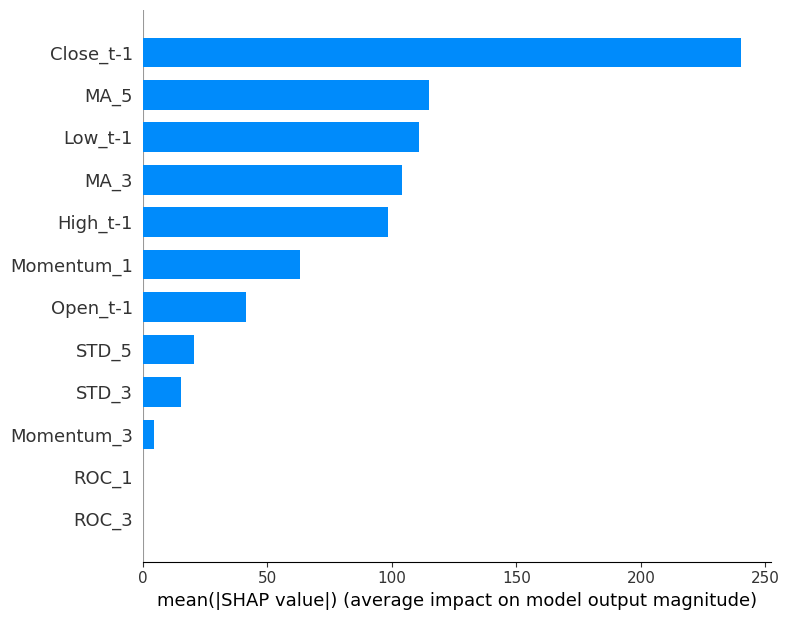

In [15]:
shap.summary_plot(shap_values, X_full_train, plot_type="bar")  # importance global

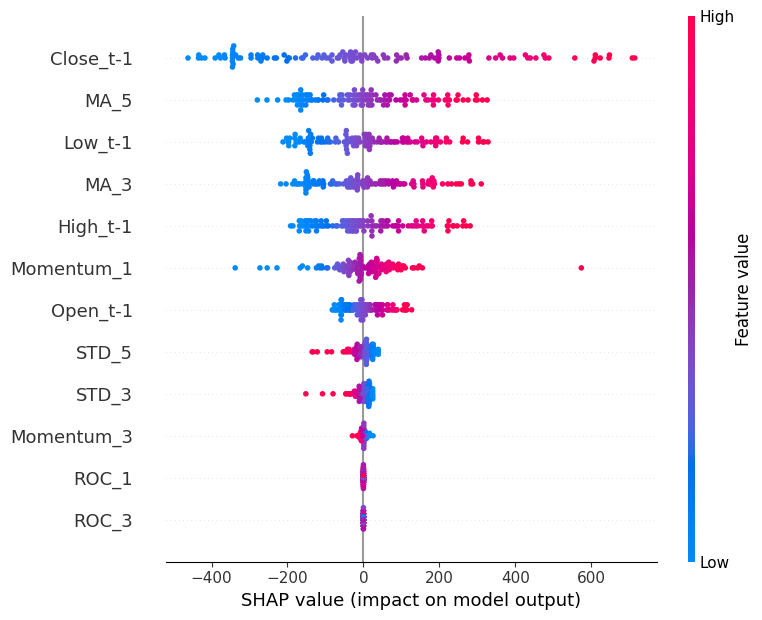

In [16]:
shap.summary_plot(shap_values, X_full_train)  # beeswarm

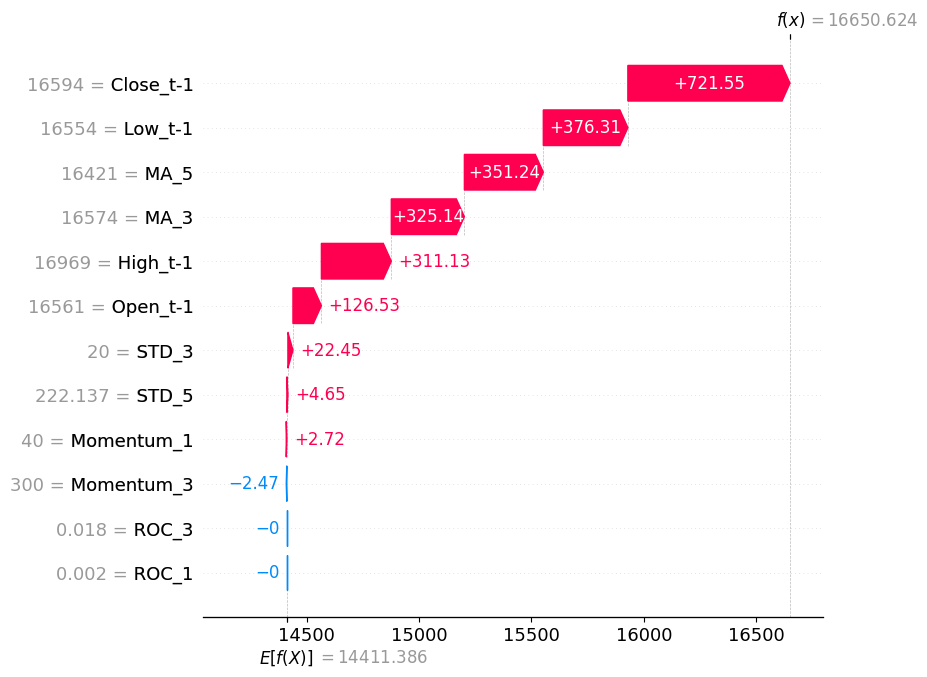

In [17]:
shap_values_latest = explainer(X_latest)
shap.plots.waterfall(shap_values_latest[0], max_display=20)